In [68]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.externals import joblib
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['SimHei']

该成本模型由蒋文博编写，主要考虑每一次故障维修以后能够update数据集，在随机增加故障以后维保时间间隔按预期变小，但无法随着时间的增加而让维保稳定在一天。

In [114]:
class BestMaintenanceInterval:
    def __init__(self, equipment_data):
        equipment_data.sort_values(by=['date'], inplace=True)
        equipment_data.reset_index(inplace=True)
        self.equipment_data = equipment_data
        self.cp = 400
        self.cf = 1600
    
    def h_function(self, t, x):
        '''
        t: int
        x: np.array, Action, Business, ContractType, CityLV, TH, MM_Mono, MM_Mini
        '''
        #print(t)
        beta = np.array([-0.091, 0.015, 0.049, 0.109, 0.051, 0.121, -0.136])
        h = (t/111.634)**0.652 * np.exp(np.dot(beta, x))
        #print(h)
        return h
    
    def failure_num(self, delta_t, T, t, x, predictive_num):
        '''
        计算故障次数，包括失效风险
        delta_t: 保养间隔
        T: 预测得下次故障间隔
        t: 距离上一次故障的时间间隔
        '''
        if T > t:
            #预测的故障日期在当前日期之后
            remaining_life = T - t
            #print(remaining_life)
            if delta_t <= remaining_life:
                #在本月不会发生下一次故障
                #print('a')
                failure_risk = self.h_function(delta_t+t, x) - self.h_function(t, x) + (predictive_num - 1)*self.h_function(delta_t, x) + self.h_function(30-predictive_num*delta_t, x)
            elif delta_t <= T:
                #print('b')
                #在本月发生一次故障后不再发生故障
                failure_risk = 1 + self.h_function(T, x) - self.h_function(t, x) + self.h_function(delta_t-T+t, x) + (predictive_num - 1)*self.h_function(delta_t, x) + self.h_function(30-predictive_num*delta_t, x)
            else:
                #print('c')
                #在本月会发生多次故障
                failure_risk = self.h_function(T, x) - self.h_function(t, x) + 1
                countdown = 30- (T - t)
                remaining_predictive_time = delta_t - T + t
                remaining_failure_time = T
                while countdown > 0:
                    if countdown < min(remaining_failure_time, remaining_predictive_time):
                        failure_risk += self.h_function(countdown, x)
                        countdown = 0
                    else:
                        if remaining_failure_time < remaining_predictive_time:
                            failure_risk += (1 + self.h_function(T, x))
                            countdown -= remaining_failure_time
                            remaining_predictive_time -= remaining_failure_time
                        else:
                            failure_risk += self.h_function(remaining_predictive_time, x)
                            countdown -= remaining_predictive_time
                            remaining_predictive_time = delta_t            
        else:
            #print('d')
            #预测的故障日期在当前日期之前
            failure_risk = 1
            failure_risk += self.failure_num(delta_t, T, 0, x, predictive_num)
        return failure_risk
    
    def cost_equipment(self, delta_t, T, t, x):
        '''
        单台设备的成本，包括维护成本与故障成本
        delta_t: 保养间隔
        T: 预测得下次故障间隔
        t: 距离上一次故障的时间间隔
        '''
        predictive_count = 30 // delta_t
        predictive_cost = 30 / delta_t * self.cp
        failure_count = self.failure_num(delta_t, T, t, x, predictive_count)
        failure_cost = failure_count * self.cf
        #print(failure_count)
        total_cost = predictive_cost + failure_cost
        #print(predictive_cost, failure_cost)
        return total_cost
    
    def select_equipment(self):
        '''
        获取电梯相关数据
        return: dict, key=equip_no, values=equip_info
        '''
        equipments = {}
        for i in self.equipment_data.index:
            cur_date = self.equipment_data.loc[i, 'date']
            if cur_date >= self.date:
                break
            else:
                equip_no = self.equipment_data.loc[i, 'equip_no']
                predict_failure = self.equipment_data.loc[i, 'next_repair'] #T, int
                covariable = np.array(self.equipment_data.loc[i, ['Action', 'Business', 'ContractType', 'CityLV', 'TH', 'MM_Mono', 'MM_Mini']]) #x, array
                tt = (self.date - cur_date).days #t, int
                equip_info = {'T': predict_failure, 'x': covariable, 't': tt}
                equipments[equip_no] = equip_info
        #print(len(equipments))
        return equipments
    
    def get_equipment(self):
        equipments = {}
        for i in self.equipment_data.index:
            cur_date = self.equipment_data.loc[i, 'date']
            if cur_date >= self.date:
                break
            else:
                equip_no = self.equipment_data.loc[i, 'equip_no']
                predict_failure = self.equipment_data.loc[i, 'next_repair'] #T, int
                covariable = np.array(self.equipment_data.loc[i, ['Action', 'Business', 'ContractType', 'CityLV', 'TH', 'MM_Mono', 'MM_Mini']]) #x, array
                tt = (self.date - cur_date).days #t, int
                equip_info = {'T': predict_failure, 'x': covariable, 't': tt}
                equipments[equip_no] = equip_info
        #print(len(equipments))
        return predict_failure,covariable,tt
    
    def total_cost(self, delta_t):
        '''
        计算所有电梯（已出现）的总成本
        '''
        equipments = self.select_equipment()
        cost = 0
        for equip_info in equipments.values():
            cur_cost = self.cost_equipment(delta_t, equip_info['T'], equip_info['t'], equip_info['x'])
            cost += cur_cost
        #print(equip_info['x'])
        return cost
    
    def optimize_delta_t(self, date):
        '''
        寻找最优delta_t
        '''
        self.date = date
        best_delta_t = 1
        min_cost = self.total_cost(1)
        #res = [min_cost]
        for dt in range(2, 31):
            cur_cost = self.total_cost(dt)
            #res.append(cur_cost)
            #print(cur_cost)
            if cur_cost <= min_cost:
                min_cost = cur_cost
                best_delta_t = dt
        #return min_cost
        return best_delta_t

In [11]:
test_sample = pd.read_csv('test_sample6.csv')

In [12]:
test_sample['date'] = test_sample['date'].apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

In [4]:
def error_func(y_true, y_pred):
    error = y_pred - y_true
    error_penalty = np.array(list(map(lambda x: ((math.e)**(x/7)-1) if x >= 0 else ((math.e)**(-x/10)-1), error)))
    #return error_penalty
    return np.mean(error_penalty)
model = joblib.load('xgb_all.joblib')
data_test = np.array(test_sample[['lowbound', 'median', 'mean', 'upbound']])
test_sample['predict_failure'] = model.predict(data_test)

In [83]:
date = datetime(2014,8,1)
preds=[]
covs=[]
for i in tqdm_notebook(range(6)):
    equipment_data = test_sample[test_sample['label'] == i]
    m= BestMaintenanceInterval(equipment_data.copy(deep=True))
    m.optimize_delta_t(date)
    tmp=m.get_equipment()
    preds.append(tmp[0])
    covs.append(tmp[1])

A Jupyter Widget

334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758



In [84]:
preds

[22, 10, 6, 6, 4, 2]

In [13]:
date = datetime(2014,6,1)
for i in range(6):
    equipment_data = test_sample[test_sample['label'] == i]
    locals()['BestMaintenance' + str(i)] = BestMaintenanceInterval(equipment_data.copy(deep=True))
    locals()['delta_t' + str(i)] = (locals()['BestMaintenance' + str(i)]).optimize_delta_t(date)
print(delta_t0, delta_t1, delta_t2, delta_t3, delta_t4, delta_t5)

KeyboardInterrupt: 

In [168]:
date = datetime(2014,8,1)
for i in range(6):
    equipment_data = test_sample[test_sample['label'] == i]
    locals()['BestMaintenance' + str(i)] = BestMaintenanceInterval(equipment_data.copy(deep=True))
    locals()['delta_t' + str(i)] = (locals()['BestMaintenance' + str(i)]).optimize_delta_t(date)
print(delta_t0, delta_t1, delta_t2, delta_t3, delta_t4, delta_t5)

12 8 4 4 4 3


In [61]:
date = datetime(2014,6,12)
for i in range(6):
    equipment_data = test_sample[test_sample['label'] == i]
    locals()['BestMaintenance' + str(i)] = BestMaintenanceInterval(equipment_data.copy(deep=True))
    locals()['delta_t' + str(i)] = (locals()['BestMaintenance' + str(i)]).optimize_delta_t(date)
print(delta_t0, delta_t1, delta_t2, delta_t3, delta_t4, delta_t5)

144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
613
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
740
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
757
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
24 24 6 4 3 3


In [169]:
date = datetime(2014,10,1)
for i in range(6):
    equipment_data = test_sample[test_sample['label'] == i]
    locals()['BestMaintenance' + str(i)] = BestMaintenanceInterval(equipment_data.copy(deep=True))
    locals()['delta_t' + str(i)] = (locals()['BestMaintenance' + str(i)]).optimize_delta_t(date)
print(delta_t0, delta_t1, delta_t2, delta_t3, delta_t4, delta_t5)

16 8 4 4 4 6


In [186]:
date = datetime(2014,8,1)
for i in range(6):
    equipment_data = test_sample[test_sample['label'] == i]
    locals()['BestMaintenance' + str(i)] = BestMaintenanceInterval(equipment_data.copy(deep=True))
    locals()['delta_t' + str(i)] = (locals()['BestMaintenance' + str(i)]).optimize_delta_t(date)
print(delta_t0, delta_t1, delta_t2, delta_t3, delta_t4, delta_t5)

12 8 6 4 4 3


In [188]:
date = datetime(2014,8,1)
for i in range(6):
    equipment_data = test_sample[test_sample['label'] == i]
    locals()['BestMaintenance' + str(i)] = BestMaintenanceInterval(equipment_data.copy(deep=True))
    locals()['delta_t' + str(i)] = (locals()['BestMaintenance' + str(i)]).optimize_delta_t(date)
print(delta_t0, delta_t1, delta_t2, delta_t3, delta_t4, delta_t5)

12 8 4 4 3 3


In [190]:
date = datetime(2014,8,1)
for i in range(6):
    equipment_data = test_sample[test_sample['label'] == i]
    locals()['BestMaintenance' + str(i)] = BestMaintenanceInterval(equipment_data.copy(deep=True))
    locals()['delta_t' + str(i)] = (locals()['BestMaintenance' + str(i)]).optimize_delta_t(date)
print(delta_t0, delta_t1, delta_t2, delta_t3, delta_t4, delta_t5)

24 24 6 4 4 3


In [7]:
date = datetime(2014,8,1)
for i in range(6):
    equipment_data = test_sample[test_sample['label'] == i]
    locals()['BestMaintenance' + str(i)] = BestMaintenanceInterval(equipment_data.copy(deep=True))
    locals()['delta_t' + str(i)] = (locals()['BestMaintenance' + str(i)]).optimize_delta_t(date)
print(delta_t0, delta_t1, delta_t2, delta_t3, delta_t4, delta_t5)

KeyboardInterrupt: 

In [54]:
model=BestMaintenanceInterval( test_sample[test_sample['label'] == 0])

C:\Software\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
date = datetime.datetime(2014,6,12)
delta_t=model.optimize_delta_t(date)
model.total_cost(delta_t)

144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144


42160.0

In [52]:
import datetime
a=test_sample[test_sample['label'] == 0]
date = datetime.datetime(2014,6,1)
dates_=[x for x in a['date']]
dates_=np.array(dates_)
dates_filter=datetime.datetime(2014,7,1)
index=((dates_>=date) & (dates_<=dates_filter) )
index=np.where(index)[0]
len(index)

178

In [58]:
# 成本


220.67796610169492

In [72]:
delta_t=[17,8,6,4,4,3]

In [66]:
date = datetime(2014,8,1)
dellta_t=[]
for i in tqdm_notebook(range(6)):
    equipment_data = test_sample[test_sample['label'] == i]
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    delta_t.append(tmp.optimize_delta_t(date))
print(delta_t)

A Jupyter Widget

334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
714
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
755
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758
758

[24, 24, 6, 4, 4, 3]


In [106]:
dellta_t_Aug=[]
equipment_data = test_sample[test_sample['label'] == 0]
for i in tqdm_notebook(range(1,32)):
    date = datetime(2014,8,i)    
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    dellta_t_Aug.append(tmp.optimize_delta_t(date))
print(dellta_t_Aug)

A Jupyter Widget

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [117]:
dellta_t_Aug=[]
equipment_data = test_sample[test_sample['label'] == 0]
for i in tqdm_notebook(range(1,32)):
    date = datetime(2014,8,i)    
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    dellta_t_Aug.append(tmp.optimize_delta_t(date))
print(dellta_t_Aug)

A Jupyter Widget

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 12, 12, 12]


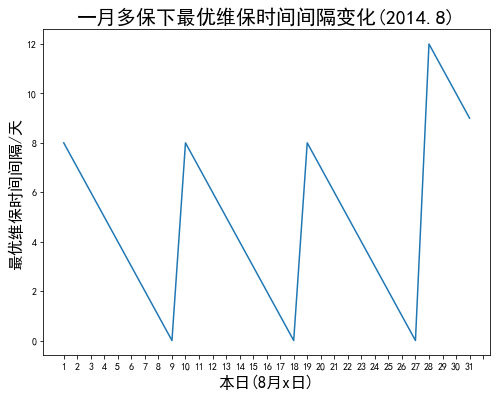

In [118]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
x_ticks=[]
d=[8,7, 6, 5, 4, 3, 2, 1, 0, 8, 7, 6, 5, 4, 3, 2, 1, 0, 8, 7, 6, 5, 4, 3, 2, 1, 0, 12, 11, 10, 9]
ax.plot(d)
ax.set_xticks(range(0,32))
ax.set_xticklabels(np.arange(1,32,1))
plt.xlabel('本日(8月x日)',fontsize=16)
plt.ylabel('最优维保时间间隔/天',fontsize=16)
plt.title('一月多保下最优维保时间间隔变化(2014.8)',fontsize=20)
plt.savefig('一月多保下最优维保时间间隔变化.png')

In [107]:
dellta_t_sep=[]
equipment_data = test_sample[test_sample['label'] == 0]
for i in tqdm_notebook(range(1,31)):
    date = datetime(2014,9,i)    
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    dellta_t_sep.append(tmp.optimize_delta_t(date))
print(dellta_t_sep)

A Jupyter Widget

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [109]:
dellta_t_june=[]
equipment_data = test_sample[test_sample['label'] == 0]
for i in tqdm_notebook(range(1,31)):
    date = datetime(2014,6,i)    
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    dellta_t_june.append(tmp.optimize_delta_t(date))
print(dellta_t_june)

A Jupyter Widget

[12, 12, 12, 12, 12, 24, 24, 12, 12, 12, 24, 24, 24, 24, 24, 24, 12, 12, 24, 24, 24, 24, 24, 24, 24, 12, 24, 12, 24, 12]


In [110]:
dellta_t_july=[]
equipment_data = test_sample[test_sample['label'] == 0]
for i in tqdm_notebook(range(1,32)):
    date = datetime(2014,7,i)    
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    dellta_t_july.append(tmp.optimize_delta_t(date))
print(dellta_t_july)

A Jupyter Widget

[12, 12, 12, 24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [111]:
dellta_t_Dec=[]
equipment_data = test_sample[test_sample['label'] == 0]
for i in tqdm_notebook(range(1,31)):
    date = datetime(2014,12,i)    
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    dellta_t_Dec.append(tmp.optimize_delta_t(date))
print(dellta_t_Dec)

A Jupyter Widget

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [112]:
dellta_t_Oct=[]
equipment_data = test_sample[test_sample['label'] == 0]
for i in tqdm_notebook(range(1,32)):
    date = datetime(2014,10,i)    
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    dellta_t_Oct.append(tmp.optimize_delta_t(date))
print(dellta_t_Oct)

A Jupyter Widget

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [115]:
dellta_t_Oct=[]
equipment_data = test_sample[test_sample['label'] == 0]
for i in tqdm_notebook(range(1,32)):
    date = datetime(2014,10,i)    
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    dellta_t_Oct.append(tmp.optimize_delta_t(date))
print(dellta_t_Oct)

A Jupyter Widget

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


In [113]:
dellta_t_Nov=[]
equipment_data = test_sample[test_sample['label'] == 0]
for i in tqdm_notebook(range(1,31)):
    date = datetime(2014,11,i)    
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    dellta_t_Nov.append(tmp.optimize_delta_t(date))
print(dellta_t_Nov)

A Jupyter Widget

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [116]:
dellta_t_Nov=[]
equipment_data = test_sample[test_sample['label'] == 0]
for i in tqdm_notebook(range(1,31)):
    date = datetime(2014,11,i)    
    tmp=BestMaintenanceInterval(equipment_data.copy(deep=True))
    dellta_t_Nov.append(tmp.optimize_delta_t(date))
print(dellta_t_Nov)

A Jupyter Widget

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


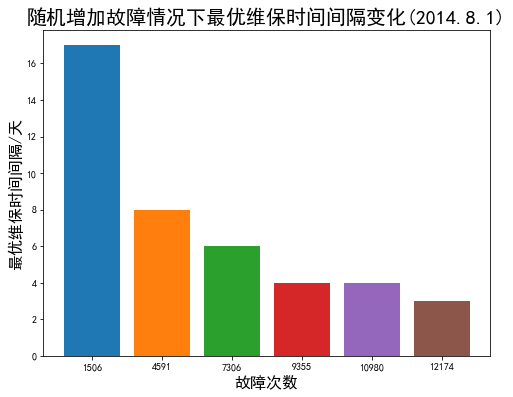

In [74]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
x_ticks=[]
for lab in range(0,6):
    ax.bar(lab,delta_t[lab])
ax.set_xticks(range(0,6))
ax.set_xticklabels([1506,4591,7306,9355,10980,12174])
plt.xlabel('故障次数',fontsize=16)
plt.ylabel('最优维保时间间隔/天',fontsize=16)
plt.title('随机增加故障情况下最优维保时间间隔变化(2014.8.1)',fontsize=20)
plt.savefig('随机增加故障情况下最优维保时间间隔变化.png')

In [96]:
def h_function(t, x):
    '''
    t: int
    x: np.array, Action, Business, ContractType, CityLV, TH, MM_Mono, MM_Mini
    '''
    #print(t)
    beta = np.array([-0.091, 0.015, 0.049, 0.109, 0.051, 0.121, -0.136])
    h = (t/111.634)**0.652 * np.exp(np.dot(beta, x))
    #print(h)
    return h

In [97]:
h_function(1,covs[lab])

0.5192721640983957

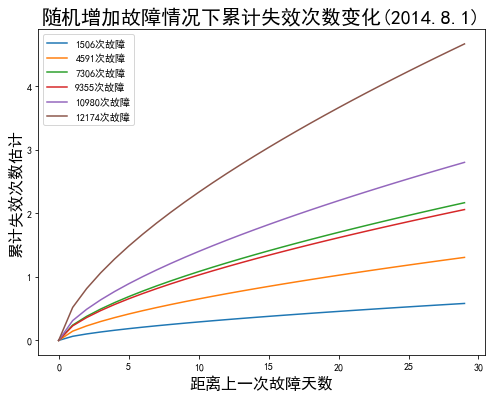

In [101]:
#tt=[1.5830013280212483,13.610324548028752,16.369696140158773,20.759593800106895,23.55464480874317,24.029735501889274]
fig,ax=plt.subplots(1,1,figsize=(8,6))
x_ticks=[]
x=list(range(30))
labs=[1506,4591,7306,9355,10980,12174]
for lab in range(len(covs)):
    ax.plot(x,[h_function(e,covs[lab]) for e in x],label='{:}次故障'.format(labs[lab]))
#ax.set_xticks(range(30))
#ax.set_xticklabels(np.arange(0,30,3))
plt.legend()
plt.xlabel('距离上一次故障天数',fontsize=16)
plt.ylabel('累计失效次数估计',fontsize=16)
plt.title('随机增加故障情况下累计失效次数变化(2014.8.1)',fontsize=20)
plt.savefig('随机增加故障情况下累计失效次数变化.png')

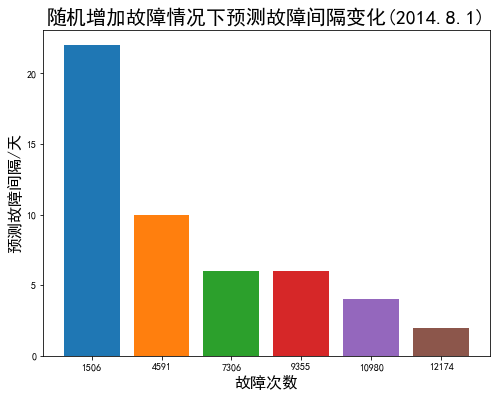

In [87]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
x_ticks=[]
for lab in range(0,6):
    ax.bar(lab,preds[lab])
ax.set_xticks(range(0,6))
ax.set_xticklabels([1506,4591,7306,9355,10980,12174])
plt.xlabel('故障次数',fontsize=16)
plt.ylabel('预测故障间隔/天',fontsize=16)
plt.title('随机增加故障情况下预测故障间隔变化(2014.8.1)',fontsize=20)
plt.savefig('随机增加故障情况下预测故障间隔变化.png')